<div style="text-align: center; font-size: 30pt; font-weight: bold; margin: 1em 0em 1em 0em">Homework 2</div>

$\textbf{Auteur}$ : Adel Nabli


$\textbf{ID}$: 20121744

In [1]:
import numpy as np
from scipy import special, linalg
import matplotlib.pyplot as plt

In [2]:
A_train = np.loadtxt('classificationA.train')
A_test = np.loadtxt('classificationA.test')
B_train = np.loadtxt('classificationB.train')
B_test = np.loadtxt('classificationB.test')
C_train = np.loadtxt('classificationC.train')
C_test = np.loadtxt('classificationC.test')

## Generative model (Fisher LDA)

On suppose que nous avons séparé nos données d'entraînement en une matrice $X$ de dimenson $N \times 2$, $X=\begin{pmatrix} x_{1}^T \\ ...\\ x_{N}^T \end{pmatrix}$, avec $\forall n \in [\![1,N]\!], \; x_{n} \in \mathbb{R}^2$ et un vecteur $Y = (y_1...y_N)^T$ de dimension $N$ tel que $\forall n \in [\![1,N]\!], y_{n} \in \{0, 1 \}$


### Estimateurs de maximum de vraissemblance:

Nous avons trouvé les différents estimateurs de maximum de vraissemblance suivants:

$\hat{\pi} = \dfrac{1}{N} \sum_{n=1}^N y_n$    ;    $\hat{\mu_1} = \dfrac{\sum_{n=1}^N x_n y_n}{\sum_{n=1}^N y_n}$    ;    $\hat{\mu_0} = \dfrac{\sum_{n=1}^N x_n(1- y_n)}{N- \sum_{n=1}^N y_n}$    ;    $\hat{\Sigma} = \dfrac{1}{N} \sum_{n=1}^N [ y_n (x_n - \mu_1) (x_n - \mu_1)^T + (1-y_n)(x_n - \mu_0)(x_n - \mu_0)^T]$


### Decision boundary:

On veut tracer la droite du plan définie par $p(y=1 \; | \; x)= \dfrac{1}{2}$. 

En posant $\beta ^T = (\mu_1 - \mu_0)^T \Sigma ^{-1}$ et $\gamma = \dfrac{1}{2} (\mu_1 - \mu_0)^T \Sigma^{-1}(\mu_1+\mu_0) - \log (\dfrac{\pi}{1-\pi})$, on a:

$p(y=1 \; | \; x)= \dfrac{1}{2} \iff \dfrac{1}{1+\exp(-\beta^Tx+\gamma)}=\dfrac{1}{2} \iff (\beta_1 \; \beta_2) \begin{pmatrix} x_1 \\ x_2 \end{pmatrix} = \gamma \iff \beta_1 x_1 + \beta_2 x_2 = \gamma$

In [3]:
class fisher_LDA(object):
    
    def __init__(self):
        
        self.N = 1
        self.pi = None
        self.mu1 = None
        self.mu0 = None
        self.Sigma = None
        self.beta = None
        self.gamma = None
        
    def train(self, X, y):
        
        """learns the parameters of the distribution utilizing MLE"""
        
        self.N = len(X)
        self.pi = np.sum(y)/self.N
        self.mu1 = np.dot(y.T,X).T / np.sum(y)
        self.mu0 = np.dot((1-y).T,X).T / (self.N - np.sum(y))
        
        sigma = np.zeros((2,2))
        
        for n in range(self.N):
            
            sigma += y[n]*np.tensordot(X[n]-self.mu1, (X[n]-self.mu1).T, axes=0) + (1-y[n])*np.tensordot(X[n]-self.mu0, (X[n]-self.mu0).T, axes=0)

        self.Sigma = sigma / self.N
        
    def decision_boundary(self, borne_inf, borne_sup, nb_points):
        
        """Returns the coordinates of nb_points evenly spaced points of the decision boundary in a given window"""
        
        inv_Sigma = np.linalg.inv(self.Sigma)
        self.beta = np.dot(inv_Sigma, self.mu1-self.mu0)
        self.gamma = 0.5 * np.dot((self.mu1 - self.mu0).T, np.dot(inv_Sigma, self.mu0+self.mu1)) - np.log(self.pi) + np.log(1-self.pi)
        
        if self.beta[1] == 0:
            
            if self.beta[0] == 0:
                
                raise ValueError('Beta is the nul vector !')
            
            else:
                
                return( (self.gamma / self.beta[0] )*np.ones(nb_points), np.linspace(borne_inf, borne_sup, nb_points) )
        
        else:
            
            x1 = np.linspace(borne_inf, borne_sup, nb_points)
            return( x1, (self.gamma - self.beta[0]*x1)/self.beta[1] )
    
    def predict(self, X):
        
        """Returns the computed probability p(y=1 | x) for each test point"""
        
        return(special.expit(X.dot(self.beta) - self.gamma))
        

### Note:

Nous allons définir ici la fonction "Performance" qui nous permettra de générer toutes les métriques et graphiques demandés dans les questions précédentes. Cela nous permettra de seulement faire des appels à cette fonction par la suite pour afficher les résultats attendus.

In [4]:
def Performance(Data_train, Data_test, dataset_name, model_name):
    
    """
    * Plot the data as a point cloud in R^2 and plot the decision boundary for a given train set and model
    * Compute the misclassification error on a given training and test set for a given model
    """
    
    # On extrait les matrices X et y de nos données
    
    X_train, X_test = Data_train[:, :2], Data_test[:, :2]
    y_train, y_test = Data_train[:, 2], Data_test[:, 2]
    
    # On entraine le modele désiré sur les données d'entrainement
    
    if model_name == 'fisher_LDA':
        
        model = fisher_LDA()
    
    elif model_name == 'logistic_regression':
        
        model = logistic_regression(epsilon=0.001)
        
        # On ajoute une colonne de 1 à nos matrices X
        
        X_train = np.concatenate((np.ones((len(X_train),1)), X_train), axis=1)
        X_test = np.concatenate((np.ones((len(X_test),1)), X_test), axis=1)
    
    elif model_name == 'linear_regression':
        
        model = linear_regression()
        
        # On ajoute une colonne de 1 à nos matrices X
        
        X_train = np.concatenate((np.ones((len(X_train),1)), X_train), axis=1)
        X_test = np.concatenate((np.ones((len(X_test),1)), X_test), axis=1)
    
    elif model_name == 'QDA':
        
        model = QDA()
    
    else:
        
        raise ValueError('name of the model unknown')

    model.train(X_train, y_train)
    
    # On calcule les coordonnées d'un ensemble de points de la "decision boundary"
    
    borne_inf = np.min(X_train) - 1
    borne_sup = np.max(X_train) + 1
    
    if model_name == 'QDA':
        
        model.compute_parameters_decision_boundary()
        
        x1 = np.linspace(borne_inf, borne_sup, 90)
        x2 = np.linspace(borne_inf, borne_sup, 90)
        
        # On crée un échantillonage 2 dimensionnel de notre espace
        
        X_echantillonage = np.reshape([[[i,j] for i in x1] for j in x2], (len(x1)*len(x2), 2))
        
        # On prédit la probabilité d'appartenir à la classe 1 sur tous les points de notre échantillonage
        
        Y_echantillonage = model.predict(X_echantillonage)
    
    else:
        
        (x1, x2) = model.decision_boundary(borne_inf, borne_sup, 1000)
    
    # On calcule les taux de mauvaise classification sur les train et test set pour le modele
    
    y_predict_train = model.predict(X_train)
    y_predict_test = model.predict(X_test)
    
    nb_misclassification_train = len(np.where(np.abs(y_predict_train - y_train) > 0.5)[0])
    nb_misclassification_test = len(np.where(np.abs(y_predict_test - y_test) > 0.5)[0])
    
    misclassification_rate_train = nb_misclassification_train / len(y_train)
    misclassification_rate_test = nb_misclassification_test / len(y_test)
    
    print('\n Misclassification rate on the train set of ' + dataset_name + ' for the model '+ model_name +': ', nb_misclassification_train, '/', len(y_train), '=', misclassification_rate_train)
    print(' Misclassification rate on the test set of ' + dataset_name + ' for the model '+ model_name +': ', nb_misclassification_test, '/', len(y_test), '=', misclassification_rate_test)
    
    # On trace le tout sur un même graphique
    
    chgmt_indice = np.min(np.where(y_train==0))
    plt.scatter(X_train[:chgmt_indice, -2] , X_train[:chgmt_indice, -1], marker="o", color='b', label='y=1')
    plt.scatter(X_train[chgmt_indice:, -2] , X_train[chgmt_indice:, -1], marker="o", color='r', label='y=0')
    
    if model_name == 'QDA':
        
        # On trace la decision boudary p(y=1 | x) = 0.5 grâce aux calculs de Y_echantillonage
        
        plt.contour(x1, x2, np.reshape(Y_echantillonage, (len(x1), len(x2))), [0.5], colors='g')
        
    else:
        
        plt.plot(x1, x2, color='g', label = 'decision boundary')
    
    plt.title('Nuage de point du ' + dataset_name + ' et decision boundary pour le modele ' + model_name)
    plt.xlim(borne_inf, borne_sup)
    plt.ylim(borne_inf, borne_sup)
    plt.legend()
    plt.show()


 Misclassification rate on the train set of Dataset A for the model fisher_LDA:  2 / 150 = 0.013333333333333334
 Misclassification rate on the test set of Dataset A for the model fisher_LDA:  30 / 1500 = 0.02


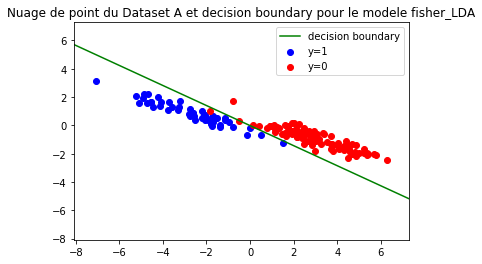


 Misclassification rate on the train set of Dataset B for the model fisher_LDA:  9 / 300 = 0.03
 Misclassification rate on the test set of Dataset B for the model fisher_LDA:  83 / 2000 = 0.0415


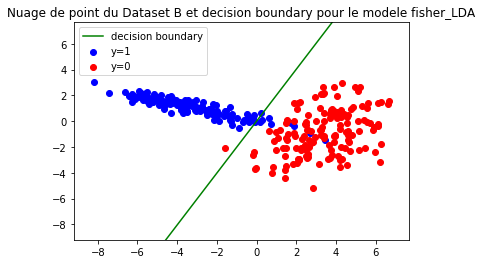


 Misclassification rate on the train set of Dataset C for the model fisher_LDA:  22 / 400 = 0.055
 Misclassification rate on the test set of Dataset C for the model fisher_LDA:  127 / 3000 = 0.042333333333333334


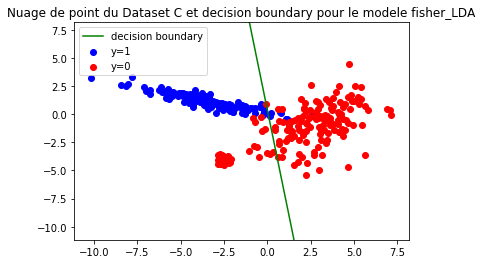

In [5]:
Performance(A_train, A_test, 'Dataset A', 'fisher_LDA')
Performance(B_train, B_test, 'Dataset B', 'fisher_LDA')
Performance(C_train, C_test, 'Dataset C', 'fisher_LDA')

## Logistic regression

* On utilisera la matrice $X$ de dimenson $ N \times (1+2)$, $X=\begin{pmatrix}  1 \; \; x_{1}^T \\ \vdots \; \; \vdots \\ 1 \; \; x_{N}^T \end{pmatrix}$ afin de se ramener à un cas linéaire et non affine.


* On veut utiliser une methode du deuxieme ordre afin de trouver le paramètre $\omega$ de notre regression ($\omega$ sera donc un vecteur de dimension $1+2 = 3$ dans notre cas).


* Dans le cas de la regression logistique, on sait que le gradient de la log-vraissemblance est: $\nabla l(\omega) = X^T (y - \mu)$ où $\mu = \sigma(X \omega)$ avec $\sigma$ la fonction sigmoïde ($\mu, \, y \in \mathbb{R}^N$).


* On sait que la Hessienne de la log vraissemblance est $H l (\omega) = - X^T D X$ avec $D=diag(\mu *( 1 - \mu))$ (ici le signe $*$ désigne la multiplication terme à terme des vecteurs)


* Ainsi, notre methode ittérative suivra le schéma numérique suivant: $\omega_{t+1} = \omega_{t} - H^{-1} l (\omega_t) \nabla l (\omega_{t})$


* On remarque que cela revient, à chaque ittération, à résoudre pour $\omega_{t+1}$ l'équation $-H l (\omega_t ) \omega_{t+1} = -H l(\omega_t) \omega_t + \nabla l (\omega_t)$, ce qui est numériquement plus stable et rapide (la héssienne étant symétrique négative et supposée inversible).


### Algorithme IRLS:

* L'utilisateur donne le $\epsilon$ pour lequel il veut faire tourner l'algorithme ($\textit{Nous avons choisit $\epsilon = 0.001$}$)


* Initialisation aléatoire de $\omega_0$ ($\textit{on utilisera une gaussienne centrée réduite pour cela}$)
* Calcul de $\mu_0 = \sigma(X \omega_0)$
* Calcul de $\nabla_0 = X^T(y-\mu_{0})$

$\textbf{ Tant que $|| \nabla_t || > \epsilon$ faire}$:

   * Calcul de $D_t = diag(\mu_t *(1-\mu_t))$
   * Calcul de $H_t = X^T D_t X$
   * Calcul de $B_t = H_t \omega_t + \nabla_t$
   * Résoudre $H_t \omega_{t+1} = B_t$ (on utilisera $scipy.linalg.solve( H, \; B, \; sym\_pos=True)$)
   * Calcul de $\mu_{t+1} = \sigma(X \omega_{t+1})$
   * Calcul de $\nabla_{t+1} = X^T(y-\mu_{t+1})$
   
### Decision boundary:

On veut tracer la droite du plan définie par $p(y=1 \; | \; x)= \dfrac{1}{2}$. 

On sait que, $\forall x \in \mathbb{R}^2$:

$p(y=1 \; | \; x)= \dfrac{1}{2} \iff \dfrac{1}{1+\exp(-\omega^Tx-b)}=\dfrac{1}{2} \iff (\omega_0 \; \omega_1 \; \omega_2) \begin{pmatrix} 1 \\ x_1 \\ x_2 \end{pmatrix} = 0$ en posant $\omega_0=  b$

Or, nous avons estimé les $w_i$ par IRLS, on se retrouve donc dans le même cas de figure qu'à la question $1$, notre code sera donc similaire.

In [6]:
class logistic_regression(object):
    
    def __init__(self, epsilon):
        
        np.random.seed(42)
        self.omega = np.random.normal(0, 1 , 3) # un vecteur de dimension 3 initialisé aléatoirement suivant une gaussienne centrée réduite
        self.epsilon = epsilon
        
    def train(self, X, y): # We suppose that X is given accordingly to the form expected described before
        
        """Use the IRLS method to find the parameter omega of the logistic regression"""
        
        mu = special.expit(np.dot(X, self.omega))
        grad = np.dot(X.T, y - mu)
        
        while np.linalg.norm(grad) > self.epsilon: # On utilise la norme de Frobenius
            
            D = np.diag(mu*(1-mu))
            H = (X.T).dot(D.dot(X))
            B = H.dot(self.omega) + grad
            self.omega = linalg.solve(H, B, sym_pos=True)
            mu = special.expit(X.dot(self.omega))
            grad = np.dot(X.T, y - mu)
        
        print('le vecteur w appris est: ', self.omega)
    
    def decision_boundary(self, borne_inf, borne_sup, nb_points):
        
        """Returns the coordinates of nb_points evenly spaced points of the decision boundary in a given window"""
        
        if self.omega[2] == 0:
            
            if self.omega[1] == 0:
                
                raise ValueError('Omega is the nul vector !')
            
            else:
                
                return( (-self.omega[0] / self.omega[1] )*np.ones(nb_points), np.linspace(borne_inf, borne_sup, nb_points) )
            
        else:
            
            x1 = np.linspace(borne_inf, borne_sup, nb_points)
            return( x1, -(self.omega[0] + self.omega[1]*x1)/self.omega[2] )
    
    def predict(self, X): # We suppose that X is given accordingly to the form expected described before
        
        """Returns the computed probability p(y=1 | x) for each test point"""
        
        return(special.expit(X.dot(self.omega)))

le vecteur w appris est:  [ -31.84064391 -189.30732858 -327.60151321]

 Misclassification rate on the train set of Dataset A for the model logistic_regression:  0 / 150 = 0.0
 Misclassification rate on the test set of Dataset A for the model logistic_regression:  52 / 1500 = 0.034666666666666665


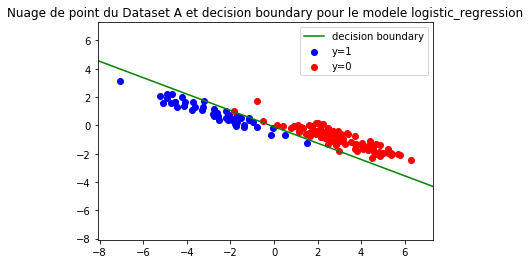

le vecteur w appris est:  [ 1.34958849 -1.70518354  1.0237838 ]

 Misclassification rate on the train set of Dataset B for the model logistic_regression:  6 / 300 = 0.02
 Misclassification rate on the test set of Dataset B for the model logistic_regression:  86 / 2000 = 0.043


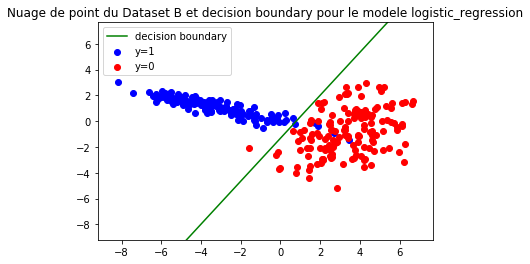

le vecteur w appris est:  [ 0.95918229 -2.20322279  0.70925896]

 Misclassification rate on the train set of Dataset C for the model logistic_regression:  16 / 400 = 0.04
 Misclassification rate on the test set of Dataset C for the model logistic_regression:  68 / 3000 = 0.02266666666666667


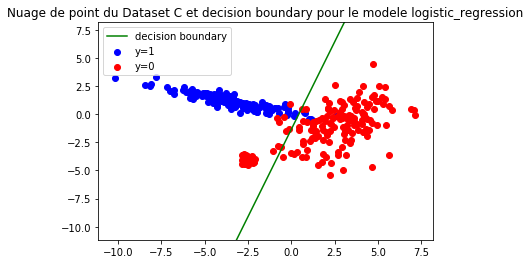

In [7]:
Performance(A_train, A_test, 'Dataset A', 'logistic_regression')
Performance(B_train, B_test, 'Dataset B', 'logistic_regression')
Performance(C_train, C_test, 'Dataset C', 'logistic_regression')

## Linear regression:

* Comme pour le cas de la régression logistique, on ajoute une colonne de 1 à notre matrice $X$ afin de nous ramener à un problème linéaire, $\omega$ est donc de nouveau de dimension $3$.


* Nous avons l'équation normale suivante: $X^T X \omega = X^T y$ . Nous allons la résoudre en utilisant de nouveau la librairie scipy et supposer $X^TX$ inversible.


* La decision boundary est définie par $f(x) = 0.5 \iff \omega^T x +b =0.5 \iff (\omega_0 \; \omega_1 \; \omega_2) \begin{pmatrix} 1 \\ x_1 \\ x_2 \end{pmatrix} = 0.5 $ en posant $\omega_0=  b$. On se retrouve donc dans un cas très similaire au cas précédent, on ne modifie ainsi que très légèrement le code par rapport à celui de la régression logistique.

In [8]:
class linear_regression(object):
    
    def __init__(self):
        
        self.omega = None
    
    def train(self, X, y): # We suppose that X is given accordingly to the form expected described before
        
        """Use the normal equation to find the parameters"""
        
        self.omega = linalg.solve((X.T).dot(X), (X.T).dot(y))
        
        print('le vecteur w appris est: ', self.omega)
    
    def decision_boundary(self, borne_inf, borne_sup, nb_points):
        
        """Returns the coordinates of nb_points evenly spaced points of the decision boundary in a given window"""
        
        if self.omega[2] == 0:
            
            if self.omega[1] == 0:
                
                raise ValueError('Omega is the nul vector !')
            
            else:
                
                return( ((0.5 - self.omega[0])/self.omega[1] )*np.ones(nb_points), np.linspace(borne_inf, borne_sup, nb_points) )
            
        else:
            
            x1 = np.linspace(borne_inf, borne_sup, nb_points)
            return( x1, (0.5-self.omega[0] - self.omega[1]*x1)/self.omega[2] )
    
    def predict(self, X): # We suppose that X is given accordingly to the form expected described before
        
        """Compute the predicted value of f(x) for each test point"""
        
        return(X.dot(self.omega))

le vecteur w appris est:  [ 0.49229204 -0.2640075  -0.37259311]

 Misclassification rate on the train set of Dataset A for the model linear_regression:  2 / 150 = 0.013333333333333334
 Misclassification rate on the test set of Dataset A for the model linear_regression:  32 / 1500 = 0.021333333333333333


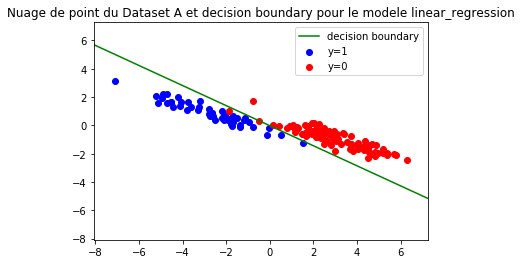

le vecteur w appris est:  [ 0.50005043 -0.10424575  0.05179118]

 Misclassification rate on the train set of Dataset B for the model linear_regression:  10 / 300 = 0.03333333333333333
 Misclassification rate on the test set of Dataset B for the model linear_regression:  84 / 2000 = 0.042


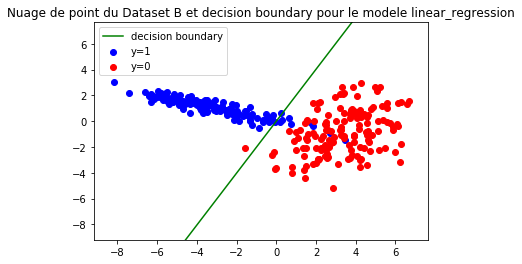

le vecteur w appris est:  [ 0.50839982 -0.12769333 -0.01700142]

 Misclassification rate on the train set of Dataset C for the model linear_regression:  25 / 400 = 0.0625
 Misclassification rate on the test set of Dataset C for the model linear_regression:  138 / 3000 = 0.046


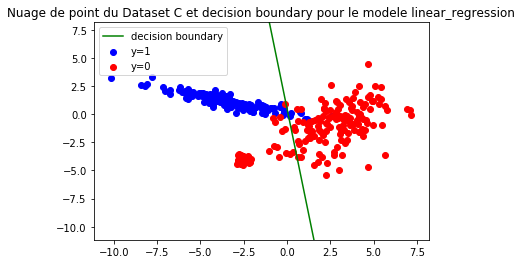

In [9]:
Performance(A_train, A_test, 'Dataset A', 'linear_regression')
Performance(B_train, B_test, 'Dataset B', 'linear_regression')
Performance(C_train, C_test, 'Dataset C', 'linear_regression')

## QDA Model:

### Estimateurs de maximum de vraissemblance:

Etant dans un cas similaire au modèle de fisher LDA sauf pour la matrice de covariance, les estimateurs de maximum de vraissemblance trouvés sont les même sauf pour $\Sigma$:

$\hat{\pi} = \dfrac{1}{N} \sum_{n=1}^N y_n$    ;    $\hat{\mu_1} = \dfrac{\sum_{n=1}^N x_n y_n}{\sum_{n=1}^N y_n}$    ;    $\hat{\mu_0} = \dfrac{\sum_{n=1}^N x_n(1- y_n)}{N- \sum_{n=1}^N y_n}$    ;    $\hat{\Sigma_1} = \dfrac{\sum_{n=1}^N y_n (x_n - \mu_1) (x_n - \mu_1)^T}{\sum_{n=1}^N y_n}$   ;   $\hat{\Sigma_0} = \dfrac{\sum_{n=1}^N (1-y_n) (x_n - \mu_0) (x_n - \mu_0)^T}{N-\sum_{n=1}^N y_n}$

### Decision boundary

On pose:

$\alpha = \dfrac{\Sigma_1^{-1} - \Sigma_0^{-1}}{2}$,   $\beta = \mu_0^T \Sigma_0^{-1}-\mu_1^T\Sigma_1^{-1}$ et    $\gamma = \dfrac{\mu_1^T \Sigma_1^{-1} \mu_1 -\mu_0^T\Sigma_0^{-1} \mu_0}{2} + \log(\dfrac{1-\pi}{\pi}\sqrt{\dfrac{|\Sigma_0^{-1}|}{|\Sigma_1^{-1}|}})$

On arrive alors à: $\forall x \in \mathbb{R}^2, \; p(y=1 \; | \; x) = \dfrac{1}{2} \iff \dfrac{1}{1+\exp(x^T \alpha x + \beta x + \gamma)} = \dfrac{1}{2}$

In [10]:
class QDA(object):
    
    def __init__(self):
        
        self.N = 1
        self.pi = None
        self.mu1 = None
        self.mu0 = None
        self.Sigma1 = None
        self.Sigma0 = None
        self.alpha = None
        self.beta = None
        self.gamma = None
        
    def train(self, X, y):
        
        """learns the parameters of the distribution utilizing MLE"""
        
        self.N = len(X)
        self.pi = np.sum(y)/self.N
        self.mu1 = np.dot(y.T,X).T / np.sum(y)
        self.mu0 = np.dot((1-y).T,X).T / (self.N - np.sum(y))
        
        sigma1 = np.zeros((2,2))
        sigma0 = np.zeros((2,2))
        
        for n in range(self.N):
            
            sigma1 += y[n]*np.tensordot(X[n]-self.mu1, (X[n]-self.mu1).T, axes=0)
            sigma0 += (1-y[n])*np.tensordot(X[n]-self.mu0, (X[n]-self.mu0).T, axes=0)

        self.Sigma1 = sigma1 / np.sum(y)
        self.Sigma0 = sigma0 / (self.N - np.sum(y))
        
        print('La valeur des estimateurs appris sont: \n')
        print(' pi = ', self.pi, ' \n mu1 = ', self.mu1, '\n mu0 = ', self.mu0, '\n Sigma1 = \n', self.Sigma1, '\n Sigma0 = \n', self.Sigma0)
        
    def compute_parameters_decision_boundary(self):
        
        """Compute the parameters alpha, beta, gamma of the decision boundary"""
        
        inv_sigma0 = np.linalg.inv(self.Sigma0)
        inv_sigma1 = np.linalg.inv(self.Sigma1)
        
        self.alpha = (inv_sigma1 - inv_sigma0)/2
        self.beta = (self.mu0.T).dot(inv_sigma0) - (self.mu1.T).dot(inv_sigma1)
        self.gamma = ((self.mu1.T).dot(inv_sigma1).dot(self.mu1) - (self.mu0.T).dot(inv_sigma0).dot(self.mu0))/2 + np.log((1-self.pi)/self.pi) + 0.5*np.log(np.linalg.det(self.Sigma1)/np.linalg.det(self.Sigma0))
        
    def predict(self, X):
        
        """Returns the computed probability p(y=1 | x) for each test point"""
        
        return(special.expit(-(np.diag((X.dot(self.alpha)).dot(X.T)) + X.dot(self.beta) + self.gamma)))
        

La valeur des estimateurs appris sont: 

 pi =  0.3333333333333333  
 mu1 =  [-2.69232004  0.866042  ] 
 mu0 =  [ 2.89970947 -0.893874  ] 
 Sigma1 = 
 [[ 2.70442172 -1.3008515 ]
 [-1.3008515   0.68969588]] 
 Sigma0 = 
 [[ 2.31065259 -1.04748461]
 [-1.04748461  0.57578403]]

 Misclassification rate on the train set of Dataset A for the model QDA:  1 / 150 = 0.006666666666666667
 Misclassification rate on the test set of Dataset A for the model QDA:  30 / 1500 = 0.02


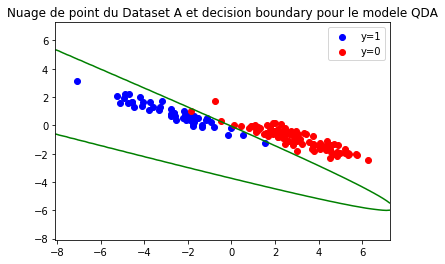

La valeur des estimateurs appris sont: 

 pi =  0.5  
 mu1 =  [-3.21670734  1.08306733] 
 mu0 =  [ 3.34068896 -0.83546333] 
 Sigma1 = 
 [[ 4.15361075 -1.33454097]
 [-1.33454097  0.51607059]] 
 Sigma0 = 
 [[2.53885859 1.0642112 ]
 [1.0642112  2.96007891]]

 Misclassification rate on the train set of Dataset B for the model QDA:  4 / 300 = 0.013333333333333334
 Misclassification rate on the test set of Dataset B for the model QDA:  40 / 2000 = 0.02


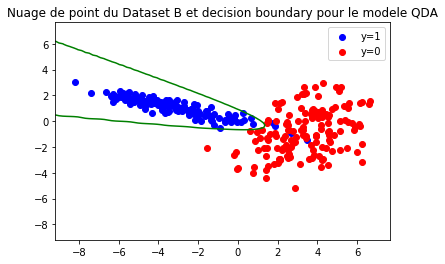

La valeur des estimateurs appris sont: 

 pi =  0.625  
 mu1 =  [-2.94232885 -0.9578284 ] 
 mu0 =  [ 2.79304824 -0.83838667] 
 Sigma1 = 
 [[ 2.86914403 -1.76197061]
 [-1.76197061  6.56438626]] 
 Sigma0 = 
 [[2.89913927 1.24581553]
 [1.24581553 2.92475448]]

 Misclassification rate on the train set of Dataset C for the model QDA:  21 / 400 = 0.0525
 Misclassification rate on the test set of Dataset C for the model QDA:  115 / 3000 = 0.03833333333333333


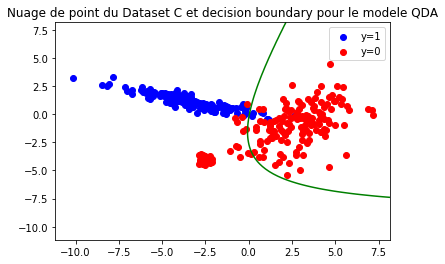

In [11]:
Performance(A_train, A_test, 'Dataset A', 'QDA')
Performance(B_train, B_test, 'Dataset B', 'QDA')
Performance(C_train, C_test, 'Dataset C', 'QDA')